# Downloading the Dataset

In [1]:
# Data hosted at below link (downloading it)
!wget https://www.dropbox.com/s/tlxserrdhe240lu/archive.zip

--2022-08-12 15:26:35--  https://www.dropbox.com/s/tlxserrdhe240lu/archive.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.5.18, 2620:100:601d:18::a27d:512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.5.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/tlxserrdhe240lu/archive.zip [following]
--2022-08-12 15:26:35--  https://www.dropbox.com/s/raw/tlxserrdhe240lu/archive.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uccae66841ba1ccaa393a9bf4238.dl.dropboxusercontent.com/cd/0/inline/Bq6f_OiErlYXHHRXaJLc0uDhkxaS7ArGaPL7otWK4jW-ZRqcBmzZzNyU-5CzED10zDGwP82zXA6ydwG3CVdQcK-aLB34q_ksDwjoaexcLZihHvosb_ho1sPYLbEW9oeEb-iMhp5KRqoiJYz9eQVXW2hy4gSU8TRVZgHGU0Ms2cF5fQ/file# [following]
--2022-08-12 15:26:36--  https://uccae66841ba1ccaa393a9bf4238.dl.dropboxusercontent.com/cd/0/inline/Bq6f_OiErlYXHHRXaJLc0uDhkxaS7ArGaPL7otWK4jW-ZRqcBmzZzNyU-5CzED10zDGwP82

In [2]:
# Unzipping the data
!unzip -q "archive.zip"

# Importing the necessary libraries

In [31]:
# Imports required for this project
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix

tf.random.set_seed(4)

# Description of the Pneumonia Dataset
**The dataset is organized into 3 folders (train, test, val) and contains subfolders for each image category (Pneumonia/Normal). There are 5,863 X-Ray images (JPEG) and 2 categories (Pneumonia/Normal).
Chest X-ray images (anterior-posterior) were selected from retrospective cohorts of pediatric patients. All chest X-ray imaging was performed as part of patients’ routine clinical care.
For the analysis of chest x-ray images, all chest radiographs were initially screened for quality control by removing all low quality or unreadable scans. The diagnoses for the images were then graded by two expert physicians before being cleared for training the AI system. In order to account for any grading errors, the evaluation set was also checked by a third expert.**

In [4]:
# Creating the Pathlib PATH objects
train_path = Path("chest_xray/train")
validation_path = Path("chest_xray/val")
test_path = Path("chest_xray/test")

In [5]:
# Collecting all the Paths Inside "Normal" and "Pneumonia" folders of the above paths
train_image_paths = train_path.glob("*/*")
val_image_paths = validation_path.glob("*/*")
test_image_paths = test_path.glob("*/*")

# Output is a Generator object
print(train_image_paths)

<generator object Path.glob at 0x7ff0307b8cd0>


In [6]:
# Convert Generator Object to List of elements 
train_image_paths = list(train_image_paths)
val_image_paths = list(val_image_paths)
test_image_paths = list(test_image_paths)

# Now the outputs are "PosixPath" objects
print(train_image_paths[:3])

[PosixPath('chest_xray/train/PNEUMONIA/person1936_bacteria_4852.jpeg'), PosixPath('chest_xray/train/PNEUMONIA/person630_bacteria_2512.jpeg'), PosixPath('chest_xray/train/PNEUMONIA/person951_bacteria_2876.jpeg')]


In [7]:
# Convert Posix paths to normal strings
train_image_paths = list(map(lambda x : str(x) , train_image_paths))
val_image_paths = list(map(lambda x : str(x) , val_image_paths)) 
test_image_paths = list(map(lambda x : str(x) , test_image_paths))

print(train_image_paths[:3])

['chest_xray/train/PNEUMONIA/person1936_bacteria_4852.jpeg', 'chest_xray/train/PNEUMONIA/person630_bacteria_2512.jpeg', 'chest_xray/train/PNEUMONIA/person951_bacteria_2876.jpeg']


In [8]:
# Collect Length for Training and Validation Datasets
train_dataset_length = len(train_image_paths)
val_dataset_length = len(val_image_paths)
test_dataset_length = len(test_image_paths)

print("Number of train image: ", train_dataset_length)
print("Number of validation image: ", val_dataset_length)
print("Number of testing image: ", test_dataset_length)

Number of train image:  5216
Number of validation image:  16
Number of testing image:  624


# Data Visualization & Preprocessing

In [9]:
# Every Image has Label in its path , so lets slice it 
LABELS = {'NORMAL' : 0 , 'PNEUMONIA' : 1}
INV_LABELS = {0 : 'NORMAL', 1 : 'PNEUMONIA'}

def get_label(path : str) -> int:
    return LABELS[path.split("/")[-2]]

train_labels = list(map(lambda x : get_label(x) , train_image_paths))
val_labels = list(map(lambda x : get_label(x) , val_image_paths))
test_labels = list(map(lambda x : get_label(x) , test_image_paths))

print(train_labels[:3])

[1, 1, 1]


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


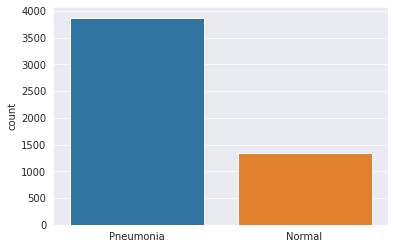

In [10]:
l = []
for i in train_labels:
    if(i == 0):
        l.append("Normal")
    else:
        l.append("Pneumonia")
sns.set_style('darkgrid')
sns.countplot(l) 

**The data seems imbalanced . To increase the no. of training examples, we will use data augmentation**

In [11]:
# Now we have all training, validation image paths and their respective labels 

BATCH_SIZE = 32

# Function used for Transformation
def load_and_transform(images, train = True):
    image = tf.io.read_file(images)
    image = tf.io.decode_jpeg(image , channels = 3)
    image = image / 255
    image = tf.image.resize(image, [224 , 224], method="nearest")
    return image

In [12]:
train_image = [load_and_transform(i) for i in train_image_paths]
train_images = np.asarray(train_image)
train_labels = np.asarray(train_labels)
print(train_images.shape)
print(train_labels.shape) 

(5216, 224, 224, 3)
(5216,)


**Previewing the images of train and validation**

PNEUMONIA


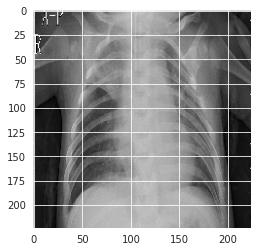

In [13]:
# View a sample Train Image
print(INV_LABELS[train_labels[0]])
plt.imshow(train_images[0].reshape(224 , 224 , 3))

In [14]:
val_image = [load_and_transform(i) for i in val_image_paths]
val_images = np.asarray(val_image)
val_labels = np.asarray(val_labels)
print(val_images.shape)
print(val_labels.shape) 

(16, 224, 224, 3)
(16,)


PNEUMONIA


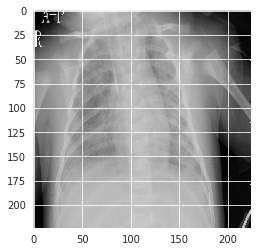

In [15]:
# View a sample Validation Image
print(INV_LABELS[val_labels[0]])
plt.imshow(val_images[0].reshape(224 , 224 , 3))

# Data Augmentation
**In order to avoid overfitting problem, we need to expand artificially our dataset. We can make your existing dataset even larger. The idea is to alter the training data with small transformations to reproduce the variations.
Approaches that alter the training data in ways that change the array representation while keeping the label the same are known as data augmentation techniques. Some popular augmentations people use are grayscales, horizontal flips, vertical flips, random crops, color jitters, translations, rotations, and much more.
By applying just a couple of these transformations to our training data, we can easily double or triple the number of training examples and create a very robust model.**

In [16]:
# With data augmentation to prevent overfitting and handling the imbalance in dataset

datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1) 


datagen.fit(train_images)

In [17]:
print(train_images.shape)
print(train_labels.shape) 

(5216, 224, 224, 3)
(5216,)


# Training the Model

In [18]:
# Building ResNet50 model
from tensorflow.keras.applications import ResNet50V2

backbone = ResNet50V2(
    input_shape=(224, 224, 3),
    include_top=False
)

model1 = tf.keras.Sequential([
    backbone,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model1.summary()

94683136/94668760 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 23,827,201
Trainable params: 23,781,761
Non

In [19]:
# Compiling your model by providing the Optimizer , Loss and Metrics
model1.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07),
    loss = 'binary_crossentropy',
    metrics=['accuracy' , tf.keras.metrics.Precision(name='precision'),tf.keras.metrics.Recall(name='recall')]
)

In [20]:
# Defining our callbacks 
checkpoint = tf.keras.callbacks.ModelCheckpoint("best_weights_resnet.h5",verbose=1,save_best_only=True,save_weights_only = True)
early_stop = tf.keras.callbacks.EarlyStopping(patience=4)
learning_rate_reduction = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)

In [21]:
# Train the model
history1 = model1.fit(
    datagen.flow(train_images,train_labels, batch_size = 32),
    steps_per_epoch=train_dataset_length//BATCH_SIZE,
    epochs=8,
    callbacks=[checkpoint , early_stop, learning_rate_reduction],
    validation_data = datagen.flow(val_images, val_labels)
)

Epoch 1/8
163/163 [==============================] - ETA: 0s - loss: 0.1611 - accuracy: 0.9323 - precision: 0.9536 - recall: 0.9554
Epoch 1: val_loss improved from inf to 1.67017, saving model to best_weights_resnet.h5
163/163 [==============================] - 90s 419ms/step - loss: 0.1611 - accuracy: 0.9323 - precision: 0.9536 - recall: 0.9554 - val_loss: 1.6702 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 0.5000 - lr: 0.0010
Epoch 2/8
163/163 [==============================] - ETA: 0s - loss: 0.1220 - accuracy: 0.9582 - precision: 0.9743 - recall: 0.9693
Epoch 2: val_loss did not improve from 1.67017
163/163 [==============================] - 67s 410ms/step - loss: 0.1220 - accuracy: 0.9582 - precision: 0.9743 - recall: 0.9693 - val_loss: 67.7821 - val_accuracy: 0.5000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - lr: 0.0010
Epoch 3/8
163/163 [==============================] - ETA: 0s - loss: 0.1057 - accuracy: 0.9601 - precision: 0.9737 - recall: 0.9726
Epo

In [22]:
history1

# Result of the Model

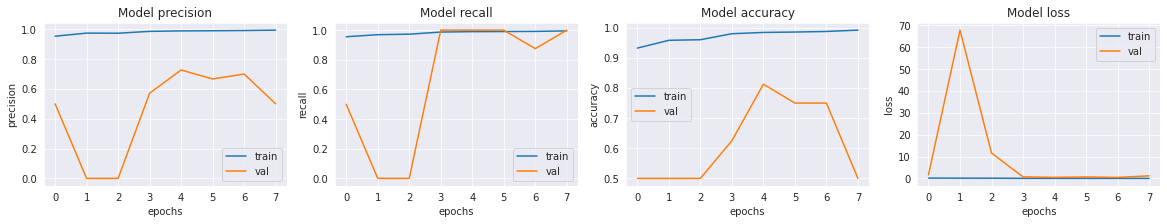

In [23]:
# Interpreting the Metrics 
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history1.history[met])
    ax[i].plot(history1.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [24]:
# Building EfficentNetB3 model
from tensorflow.keras.applications import EfficientNetB3

backbone = EfficientNetB3(
    input_shape=(224, 224, 3),
    include_top=False
)

model2 = tf.keras.Sequential([
    backbone,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model2.summary()

43950080/43941136 [==============================] - 1s 0us/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb3 (Functional)  (None, 7, 7, 1536)       10783535  
                                                                 
 global_average_pooling2d_1   (None, 1536)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_1 (Dropout)         (None, 1536)              0         
                                                                 
 dense_2 (Dense)             (None, 128)               196736    
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 10,980,400
Trainable params: 10,893,097
N

In [25]:
# Compiling your model by providing the Optimizer , Loss and Metrics
model2.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07),
    loss = 'binary_crossentropy',
    metrics=['accuracy' , tf.keras.metrics.Precision(name='precision'),tf.keras.metrics.Recall(name='recall')]
)

In [26]:
# Defining our callbacks 
checkpoint = tf.keras.callbacks.ModelCheckpoint("best_weights_efficennet.h5",verbose=1,save_best_only=True,save_weights_only = True)
early_stop = tf.keras.callbacks.EarlyStopping(patience=4)
learning_rate_reduction = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)

In [27]:
# Train the model
history2 = model2.fit(
    datagen.flow(train_images,train_labels, batch_size = 32),
    steps_per_epoch=train_dataset_length//BATCH_SIZE,
    epochs=8,
    callbacks=[checkpoint , early_stop, learning_rate_reduction],
    validation_data = datagen.flow(val_images, val_labels)
)

Epoch 1/8
163/163 [==============================] - ETA: 0s - loss: 0.1322 - accuracy: 0.9503 - precision: 0.9731 - recall: 0.9597
Epoch 1: val_loss improved from inf to 7.18894, saving model to best_weights_efficennet.h5
163/163 [==============================] - 121s 639ms/step - loss: 0.1322 - accuracy: 0.9503 - precision: 0.9731 - recall: 0.9597 - val_loss: 7.1889 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000 - lr: 0.0010
Epoch 2/8
163/163 [==============================] - ETA: 0s - loss: 0.0712 - accuracy: 0.9743 - precision: 0.9840 - recall: 0.9814
Epoch 2: val_loss improved from 7.18894 to 5.42670, saving model to best_weights_efficennet.h5
163/163 [==============================] - 98s 598ms/step - loss: 0.0712 - accuracy: 0.9743 - precision: 0.9840 - recall: 0.9814 - val_loss: 5.4267 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000 - lr: 0.0010
Epoch 3/8
163/163 [==============================] - ETA: 0s - loss: 0.0511 - accuracy: 0.9

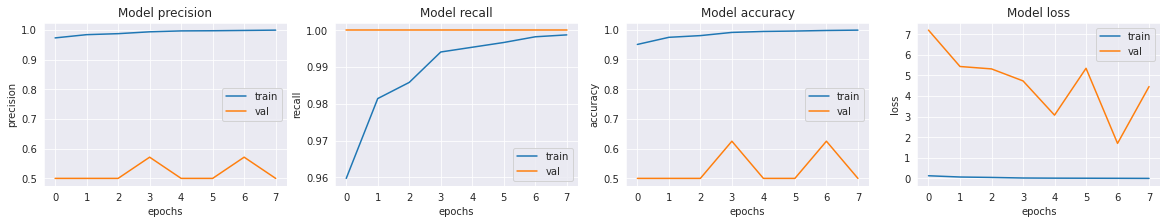

In [28]:
# Interpreting the Metrics 
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history2.history[met])
    ax[i].plot(history2.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [33]:
# Building InceptionV3 model
backbone = tf.keras.applications.inception_v3.InceptionV3(
    input_shape=(224, 224, 3),
    include_top=False
)

model3 = tf.keras.Sequential([
    backbone,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model3.summary()

87924736/87910968 [==============================] - 2s 0us/step
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 global_average_pooling2d_2   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_2 (Dropout)         (None, 2048)              0         
                                                                 
 dense_4 (Dense)             (None, 128)               262272    
                                                                 
 dense_5 (Dense)             (None, 1)                 129       
                                                                 
Total params: 22,065,185
Trainable params: 22,030,753
N

In [34]:
# Compiling your model by providing the Optimizer , Loss and Metrics
model3.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07),
    loss = 'binary_crossentropy',
    metrics=['accuracy' , tf.keras.metrics.Precision(name='precision'),tf.keras.metrics.Recall(name='recall')]
)

In [35]:
# Defining our callbacks 
checkpoint = tf.keras.callbacks.ModelCheckpoint("best_weights_inception.h5",verbose=1,save_best_only=True,save_weights_only = True)
early_stop = tf.keras.callbacks.EarlyStopping(patience=4)
learning_rate_reduction = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)

In [36]:
# Train the model
history3 = model3.fit(
    datagen.flow(train_images,train_labels, batch_size = 32),
    steps_per_epoch=train_dataset_length//BATCH_SIZE,
    epochs=8,
    callbacks=[checkpoint , early_stop, learning_rate_reduction],
    validation_data = datagen.flow(val_images, val_labels)
)

Epoch 1/8
163/163 [==============================] - ETA: 0s - loss: 0.1384 - accuracy: 0.9457 - precision: 0.9638 - recall: 0.9631
Epoch 1: val_loss improved from inf to 0.39461, saving model to best_weights_inception.h5
163/163 [==============================] - 80s 408ms/step - loss: 0.1384 - accuracy: 0.9457 - precision: 0.9638 - recall: 0.9631 - val_loss: 0.3946 - val_accuracy: 0.8125 - val_precision: 0.7778 - val_recall: 0.8750 - lr: 0.0010
Epoch 2/8
163/163 [==============================] - ETA: 0s - loss: 0.0700 - accuracy: 0.9762 - precision: 0.9830 - recall: 0.9850
Epoch 2: val_loss improved from 0.39461 to 0.15467, saving model to best_weights_inception.h5
163/163 [==============================] - 64s 390ms/step - loss: 0.0700 - accuracy: 0.9762 - precision: 0.9830 - recall: 0.9850 - val_loss: 0.1547 - val_accuracy: 0.9375 - val_precision: 1.0000 - val_recall: 0.8750 - lr: 0.0010
Epoch 3/8
163/163 [==============================] - ETA: 0s - loss: 0.0576 - accuracy: 0.9791

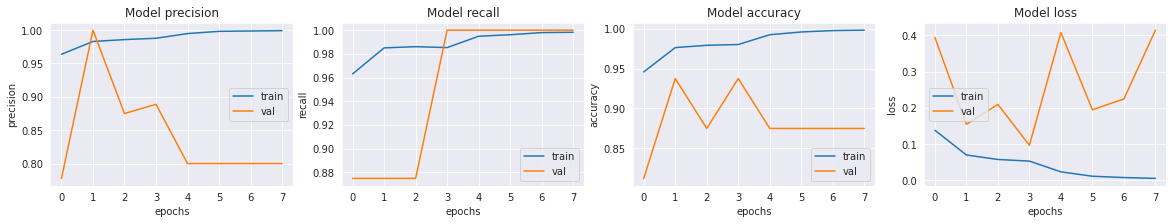

In [37]:
# Interpreting the Metrics 
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history3.history[met])
    ax[i].plot(history3.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [39]:
# Building VGG19 model
from tensorflow.keras.applications.vgg19 import VGG19

backbone = VGG19(
    input_shape=(224, 224, 3),
    include_top=False
)

model4 = tf.keras.Sequential([
    backbone,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model4.summary()

80150528/80134624 [==============================] - 1s 0us/step
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 global_average_pooling2d_3   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_3 (Dropout)         (None, 512)               0         
                                                                 
 dense_6 (Dense)             (None, 128)               65664     
                                                                 
 dense_7 (Dense)             (None, 1)                 129       
                                                                 
Total params: 20,090,177
Trainable params: 20,090,177
N

In [40]:
# Compiling your model by providing the Optimizer , Loss and Metrics
model4.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07),
    loss = 'binary_crossentropy',
    metrics=['accuracy' , tf.keras.metrics.Precision(name='precision'),tf.keras.metrics.Recall(name='recall')]
)

In [41]:
# Defining our callbacks 
checkpoint = tf.keras.callbacks.ModelCheckpoint("best_weights_vgg.h5",verbose=1,save_best_only=True,save_weights_only = True)
early_stop = tf.keras.callbacks.EarlyStopping(patience=4)
learning_rate_reduction = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)

In [42]:
# Train the model
history4 = model4.fit(
    datagen.flow(train_images,train_labels, batch_size = 32),
    steps_per_epoch=train_dataset_length//BATCH_SIZE,
    epochs=8,
    callbacks=[checkpoint , early_stop, learning_rate_reduction],
    validation_data = datagen.flow(val_images, val_labels)
)

Epoch 1/8
163/163 [==============================] - ETA: 0s - loss: 1.4857 - accuracy: 0.7320 - precision: 0.7429 - recall: 0.9775
Epoch 1: val_loss improved from inf to 0.85359, saving model to best_weights_vgg.h5
163/163 [==============================] - 89s 499ms/step - loss: 1.4857 - accuracy: 0.7320 - precision: 0.7429 - recall: 0.9775 - val_loss: 0.8536 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000 - lr: 0.0010
Epoch 2/8
163/163 [==============================] - ETA: 0s - loss: 0.5776 - accuracy: 0.7429 - precision: 0.7429 - recall: 1.0000
Epoch 2: val_loss improved from 0.85359 to 0.76444, saving model to best_weights_vgg.h5
163/163 [==============================] - 81s 492ms/step - loss: 0.5776 - accuracy: 0.7429 - precision: 0.7429 - recall: 1.0000 - val_loss: 0.7644 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000 - lr: 0.0010
Epoch 3/8
163/163 [==============================] - ETA: 0s - loss: 0.5736 - accuracy: 0.7429 - precision

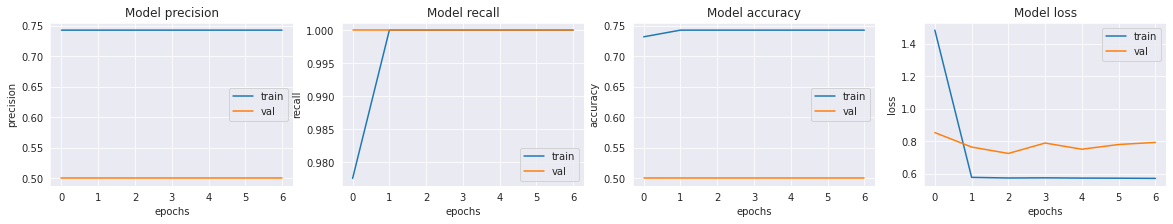

In [43]:
# Interpreting the Metrics 
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history4.history[met])
    ax[i].plot(history4.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [44]:
import pandas as pd
metrics = ['loss', 'accuracy', 'precision', 'recall', 'val_loss', 'val_accuracy', 'val_precision', 'val_recall']
models = [history1, history2, history3, history4]
model_name = ['ResNet50', 'EfficentNetB3', 'InceptionV3', 'VGG19']
best_model = []

for i in models:
  m = np.argmax(i.history['val_accuracy'])
  for j in metrics:
    best_model.append(i.history[j][m])

df = pd.DataFrame((np.array(best_model)).reshape(4,8), columns=metrics, index=model_name)

In [45]:
df

,loss,accuracy,precision,recall,val_loss,val_accuracy,val_precision,val_recall
ResNet50,0.044766,0.984279,0.989167,0.989677,0.500170,0.8125,0.727273,1.000
EfficentNetB3,0.022927,0.990798,0.993552,0.994065,4.729034,0.6250,0.571429,1.000
InceptionV3,0.070040,0.976227,0.983003,0.985032,0.154666,0.9375,1.000000,0.875
VGG19,1.485654,0.731979,0.742891,0.977548,0.853593,0.5000,0.500000,1.000


# Saving the Best Model

In [47]:
# Saving the best Model

# Load the best weights
model3.load_weights("best_weights_inception.h5")
# Save the whole model (weigths + architecture)
model3.save("model.h5")

In [48]:
# Loading the whole model
loaded_model = tf.keras.models.load_model("model.h5")

# Testing the Model

In [49]:
# Create a Dataset Object for 'Testing' Set just the way we did for Training and Validation
test_image = [load_and_transform(i) for i in test_image_paths]
test_images = np.asarray(test_image)
test_labels = np.asarray(test_labels)
print(test_images.shape)
print(test_labels.shape)

(624, 224, 224, 3)
(624,)


PNEUMONIA


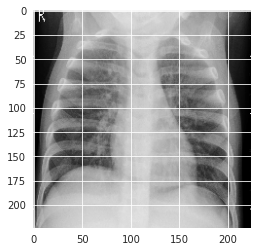

In [50]:
# Verify Test Dataset Object
# View a sample Validation Image
print(INV_LABELS[test_labels[0]])
plt.imshow(test_images[0].reshape(224 , 224 , 3))

In [51]:
# Evaluating the loaded model
loss, acc, prec, rec = loaded_model.evaluate(test_images, test_labels)

print(" Testing Loss " , loss)
print(" Testing Acc : " , acc)
print(" Testing Precision " , prec)
print(" Testing Recall " , rec)

20/20 [==============================] - 3s 79ms/step - loss: 0.4011 - accuracy: 0.9167 - precision: 0.9721 - recall: 0.8923
 Testing Loss  0.4010942578315735
 Testing Acc :  0.9166666865348816
 Testing Precision  0.9720670580863953
 Testing Recall  0.892307698726654
